In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
import numpy as np
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from pycocotools.coco import COCO
import os
import shutil
import json

In [2]:
coco = COCO('Pedestrian_dataset_for_internship_assignment/random_sample_mavi_2_gt.json')
image_ids = coco.getImgIds()
img = coco.loadImgs(image_ids[3])[0]
anns = coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
categories = coco.loadCats(coco.getCatIds())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
# Define transformations for your images (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
])

# Path to the folder where images are stored
img_dir = 'Pedestrian_dataset_for_internship_assignment/Pedestrian_dataset_for_internship_assignment/'

# Path to the COCO-style annotations JSON file
annotations_file = 'Pedestrian_dataset_for_internship_assignment/random_sample_mavi_2_gt.json'

# Paths for new train and val directories
base_dir = 'coco_dataset'
train_img_dir = os.path.join(base_dir, 'train2017')
val_img_dir = os.path.join(base_dir, 'val2017')
train_ann_file = os.path.join(base_dir, 'annotations/instances_train2017.json')
val_ann_file = os.path.join(base_dir, 'annotations/instances_val2017.json')

# Check if the train and val directories exist, if not, create them
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(os.path.dirname(train_ann_file), exist_ok=True)

# Load the COCO dataset
coco_dataset = CocoDetection(root=img_dir, annFile=annotations_file, transform=transform)

# Create a DataLoader for the dataset
def custom_collate_fn(batch):
    images, labels = zip(*batch)  # Unpack the batch
    return list(images), list(labels)

# Function to move images to the appropriate directories
def move_images(dataset, target_dir):
    os.makedirs(os.path.join(target_dir), exist_ok=True)
    # delete all existing files in the target directory
    for filename in os.listdir(target_dir):
        file_path = os.path.join(target_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path): 
            shutil.rmtree(file_path)
            
    for idx in range(len(dataset)):
        # Get image file path from dataset
        img_name = dataset.dataset.coco.loadImgs(dataset[idx][1][0]['image_id'])[0]['file_name']
        source_img_path = os.path.join(img_dir, img_name)
        target_img_path = os.path.join(target_dir, img_name)
        
        # Move image to the target directory
        if not os.path.exists(target_img_path):
            shutil.copy(source_img_path, target_img_path)
            
def save_annotations(dataset, target_file):
    # Get all the image ids from the dataset
    img_ids = [dataset[idx][1][0]['image_id'] for idx in range(len(dataset))]
    ann_file = {}
    images_list = [dataset.dataset.coco.loadImgs(img_id)[0] for img_id in img_ids]
    # Get all the annotations from the dataset
    annotations = []
    for img_id in img_ids:
        annotations += dataset.dataset.coco.imgToAnns[img_id]
        
    categories = list(dataset.dataset.coco.cats.values())
    
    json_data = {
        "images": images_list,
        "annotations": annotations,
        "categories": categories
    }
    # Save the annotations to a JSON file
    with open(target_file, 'w') as f:
        json.dump(json_data, f)
    return

# Split the dataset
train_size = int(0.8 * len(coco_dataset))
val_size = len(coco_dataset) - train_size
train_dataset, val_dataset = random_split(coco_dataset, [train_size, val_size])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [42]:
save_annotations(val_dataset, val_ann_file)
save_annotations(train_dataset, train_ann_file)

In [43]:
# Move training images to train directory and validation images to val directory
move_images(train_dataset, train_img_dir)
move_images(val_dataset, val_img_dir)
                

In [6]:
# Now update the COCO dataset paths to use the new directories
train_annotations_file = 'coco_dataset/annotations/instances_train2017.json'  # You can update the annotations file accordingly if needed
val_annotations_file = 'coco_dataset/annotations/instances_val2017.json'      # You can update the annotations file accordingly if needed

# Load the COCO datasets with new paths
train_dataset = CocoDetection(root=train_img_dir, annFile=train_annotations_file, transform=transform)
val_dataset = CocoDetection(root=val_img_dir, annFile=val_annotations_file, transform=transform)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Feature batch shape: torch.Size([3, 480, 640])
Labels batch shape: 5


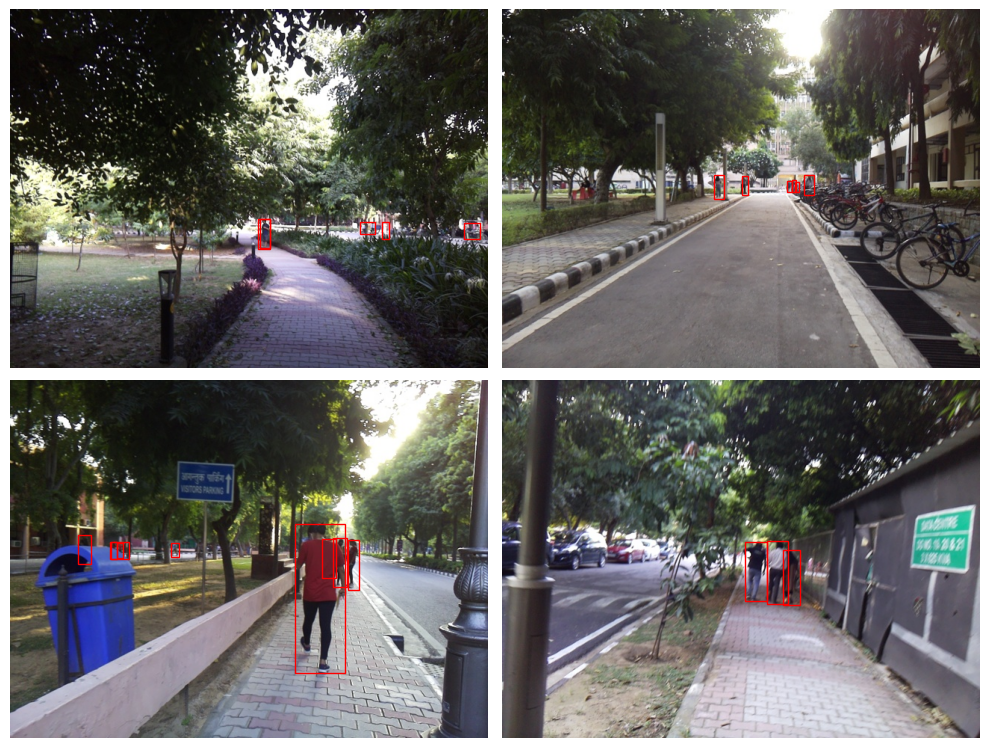

In [21]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features[0].size()}")
print(f"Labels batch shape: {len(train_labels[0])}")

# Loop through the first four images and their labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()  # Flatten the axes array to iterate easily

for i in range(4):
    img = train_features[i].squeeze()  # Remove the batch dimension
    image_array = np.transpose(img, (1, 2, 0))  # Rearrange dimensions to (H, W, C)
    ax[i].imshow(image_array)  # Display the image

    anns = train_labels[i]  # Get the annotations for the image

    # Plot each bounding box
    for ann in anns:
        bbox = ann['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    
    ax[i].axis('off')  # Hide the axis

# Show the plot
plt.subplots_adjust(wspace=-0.1, hspace=-0.6) 
plt.tight_layout()
plt.show()

In [6]:
categories

[{'id': 1, 'name': 'pedestrian', 'supercategory': 'pedestrian'}]